In [35]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

from source.make_train_test import make_teams_target, make_training_data, add_seed

import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
df = pd.read_csv('data/processed_men/game_details_regular_extended.csv')
print(df.shape)

df.head()

(92832, 138)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,def_rating_diff,def_rating_advantage,shtg_opportunity_diff,shtg_opportunity_advantage,TO_perposs_diff,TO_perposs_advantage,impact_diff,impact_advantage,True_shooting_perc_diff,True_shooting_perc_advantage
0,2003,10,1104,68,1328,62,N,0,27,58,...,-3.232650,0,-0.007160,0,0.052510,1,0.086758,1,0.022320,1
1,2003,10,1272,70,1393,63,N,0,26,62,...,-9.441729,0,-0.087813,0,0.013155,1,0.167421,1,0.081020,1
2,2003,11,1266,73,1437,61,N,0,24,58,...,-18.743237,0,-0.184579,0,-0.030448,0,0.329480,1,0.145114,1
3,2003,11,1296,56,1457,50,N,0,18,38,...,-9.338222,0,-0.067763,0,-0.122539,0,0.238095,1,0.085623,1
4,2003,11,1400,77,1208,71,N,0,30,61,...,-8.742741,0,-0.125599,0,0.061475,1,0.146245,1,0.098690,1


In [56]:
df = df[['Season', 'WTeamID', 'LTeamID', 'WScore', 'LScore']].copy()

df.head()

,Season,WTeamID,LTeamID,WScore,LScore
0,2003,1104,1328,68,62
1,2003,1272,1393,70,63
2,2003,1266,1437,73,61
3,2003,1296,1457,56,50
4,2003,1400,1208,77,71


In [57]:
df_rev = df.copy()

df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
df_rev.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(df_rev.columns)]

df = pd.concat([df, df_rev]).sort_index().reset_index(drop = True)

df.head()

,Season,T1_TeamID,T2_TeamID,T1_Score,T2_Score
0,2003,1104,1328,68,62
1,2003,1328,1104,62,68
2,2003,1393,1272,63,70
3,2003,1272,1393,70,63
4,2003,1266,1437,73,61


In [58]:
df['PointDiff'] = df['T1_Score'] - df['T2_Score']

In [59]:
regular_season_effects = df[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)

In [60]:
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

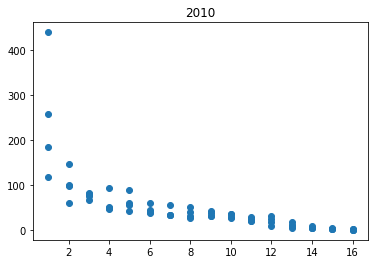

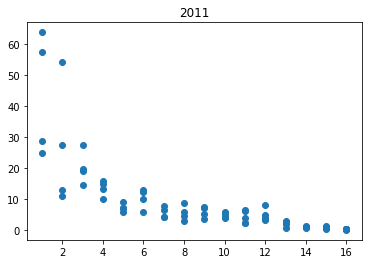

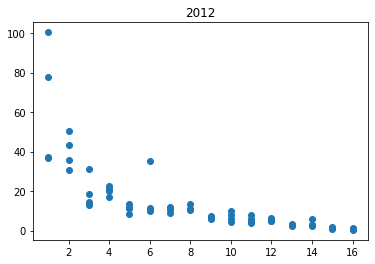

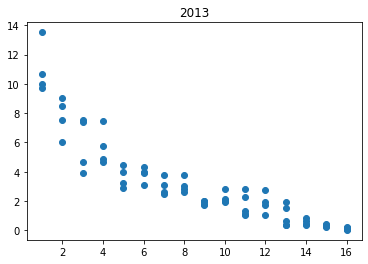

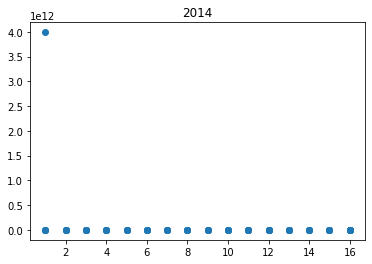

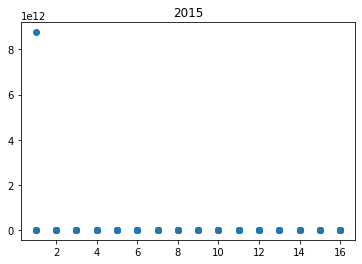

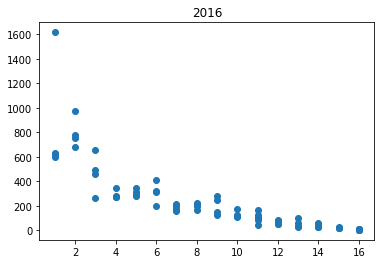

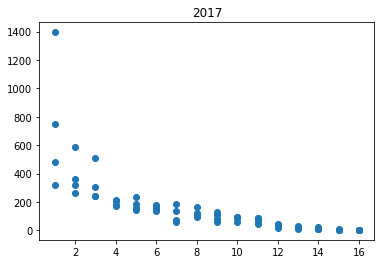

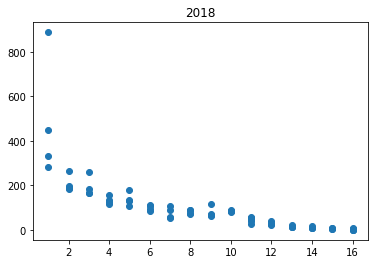

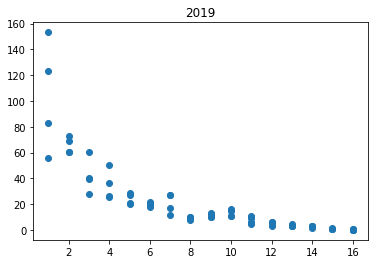

In [61]:
for year in np.arange(2010, 2020):
    seed = 'data/raw_men/M2021_Stage1/MNCAATourneySeeds.csv'

    tmp = add_seed(seed, team_quality(year))
    
    plt.scatter(x=tmp.Seed, y=tmp.quality)
    plt.title(year)
    plt.show()